## Libraries

In [212]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [214]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [215]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [216]:
import pandas as pd

In [217]:
from sklearn.model_selection import train_test_split

In [218]:
from tqdm.notebook import tqdm

In [219]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset

### データの読み込み

In [220]:
df = pd.read_csv("/content/drive/MyDrive/ColabData/kaggle-titanic/train.csv")
#print(df.info())
#df.head()

test_df = pd.read_csv("/content/drive/MyDrive/ColabData/kaggle-titanic/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [221]:
def makeDataList(csv_path):
  datalist = pd.read_csv(csv_path)
  datalist = datalist.drop(["Name", "Ticket", "Cabin"], axis=1)
  datalist = pd.get_dummies(datalist)
  datalist = datalist.fillna(-1)
  return datalist

In [222]:
datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-titanic/train.csv")

In [223]:
datalist.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [224]:
train_datalist, test_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)

In [225]:
print(train_datalist.shape)
print(test_datalist.shape)
print(train_datalist.values)
train_datalist.head()

(801, 12)
(90, 12)
[[268.   1.   3. ...   0.   0.   1.]
 [636.   1.   2. ...   0.   0.   1.]
 [474.   1.   2. ...   1.   0.   0.]
 ...
 [295.   0.   3. ...   0.   0.   1.]
 [724.   0.   2. ...   0.   0.   1.]
 [816.   0.   1. ...   0.   0.   1.]]


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
267,268,1,3,25.0,1,0,7.7750,0,1,0,0,1
635,636,1,2,28.0,0,0,13.0000,1,0,0,0,1
473,474,1,2,23.0,0,0,13.7917,1,0,1,0,0
207,208,1,3,26.0,0,0,18.7875,0,1,1,0,0
290,291,1,1,26.0,0,0,78.8500,1,0,0,0,1


### Datasetの作成

In [226]:
#DataFrameからndarrayに変換.　Datasetを継承し，DataLoaderの第一引数にできる．
class DatasetMaker(Dataset):
  def __init__(self, datalist):
    self.input_datalist = datalist.drop(["PassengerId", "Survived"], axis=1).values.astype(np.float32)
    self.label_datalist = datalist["Survived"].values.astype(np.int64)

  #lenを呼び出すための特殊メソッドで必須．
  def __len__(self):
    return len(self.input_datalist)

  #データセット内の特定の番号のinputs, labelsをndarray型で抽出できるようにする．
  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    labels = self.label_datalist[index]
    return inputs, labels

In [227]:
train_dataset = DatasetMaker(train_datalist)
test_dataset = DatasetMaker(test_datalist)
print(train_dataset.__len__())
print(train_dataset.__getitem__(index=0)[0])
print(train_dataset.__getitem__(index=0)[1])

801
[ 3.    25.     1.     0.     7.775  0.     1.     0.     0.     1.   ]
1


## DataLoader

In [228]:
batch_size = 5
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
for inputs_tmp, labels_tmp in train_dataloader:
  break
#batch_itr = iter(dataloader)
#inputs, labels = next(batch_itr)

In [229]:
print(inputs_tmp)
print(inputs_tmp.size())
print(labels_tmp)
print(labels_tmp.size())

tensor([[ 3.0000, -1.0000,  0.0000,  0.0000,  8.0500,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000],
        [ 3.0000, -1.0000,  0.0000,  0.0000,  8.0500,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000],
        [ 2.0000, 40.0000,  1.0000,  1.0000, 39.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000],
        [ 2.0000, 18.0000,  0.0000,  0.0000, 73.5000,  0.0000,  1.0000,  0.0000,
          0.0000,  1.0000],
        [ 2.0000,  5.0000,  1.0000,  2.0000, 27.7500,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000]])
torch.Size([5, 10])
tensor([0, 0, 1, 0, 1])
torch.Size([5])


## Network

In [230]:
class Net(nn.Module):
  def __init__(self, n_input, n_output, n_hidden, dropout_rate=0.1):
    super().__init__()
    self.l1 = nn.Linear(n_input, n_hidden)
    self.relu = nn.ReLU(inplace=True)
    self.l2 = nn.Linear(n_hidden, n_output)
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2
    )

  def forward(self, x):
    x = self.classifier(x)
    return x

In [231]:
n_input = len(train_dataset.__getitem__(index=0)[0])
n_output = 2
n_hidden = 64

In [232]:
net = Net(n_input, n_output, n_hidden)
net.to(device)

Net(
  (l1): Linear(in_features=10, out_features=64, bias=True)
  (relu): ReLU(inplace=True)
  (l2): Linear(in_features=64, out_features=2, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [233]:
'''
for parameter in net.named_parameters():
    print(parameter)
'''

'\nfor parameter in net.named_parameters():\n    print(parameter)\n'

In [234]:
print(net)

Net(
  (l1): Linear(in_features=10, out_features=64, bias=True)
  (relu): ReLU(inplace=True)
  (l2): Linear(in_features=64, out_features=2, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [235]:
summary(net, (n_input, ))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [2]                       --
├─Sequential: 1-1                        [2]                       --
│    └─Linear: 2-1                       [64]                      704
│    └─ReLU: 2-2                         [64]                      --
│    └─Linear: 2-3                       [2]                       130
Total params: 834
Trainable params: 834
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Loss Function

In [236]:
criterion = nn.CrossEntropyLoss()

In [237]:
def eval_loss(dataloader, device, net, criterion):
  for inputs, labels in dataloader:
    break
  inputs = inputs.to(device)
  labels = labels.to(device)
  #予測計算
  outputs = net(inputs)
  #損失計算
  loss = criterion(outputs, labels)
  return loss

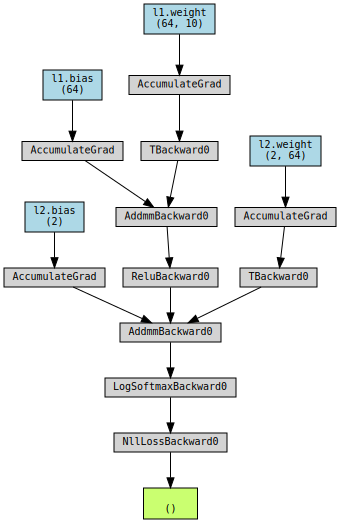

In [238]:
#損失関数の可視化
loss_test = eval_loss(test_dataloader, device, net, criterion)
g = make_dot(loss_test, params = dict(net.named_parameters()))
display(g)

## Optimizer

In [239]:
optimizer = optim.Adam(net.parameters())

## Train

In [240]:
# 学習関数
def fit(net, optimizer, criterion, num_epochs, dataloader, device, history, save_weights_path):
  base_epochs = 0 #len(history)

  for epoch in range(base_epochs, num_epochs+base_epochs):
    # 1エポックあたりの正解数(精度計算用)
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの累積損失(平均化前)
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    #訓練フェーズ
    net.train()

    for inputs, labels in tqdm(dataloader):
      # 1バッチあたりのデータ件数
      train_batch_size = len(labels)

      # 1エポックあたりのデータ累積件数
      n_train += train_batch_size

      # GPUへ
      inputs = inputs.to(device)
      labels = labels.to(device)

      # 勾配初期化
      optimizer.zero_grad()

      # 予測計算
      outputs = net(inputs)

      # 損失計算
      loss = criterion(outputs, labels)

      # バックプロパゲーション
      loss.backward()

      # パラメータ修正
      optimizer.step()

      # 予測ラベル算出
      predicted = torch.max(outputs, dim=1)[1]

      # 累積損失
      # バッチサイズで平均化されているので戻す．全バッチ終了後に平均化する．
      train_loss += loss.item() * train_batch_size

      # 正解数カウント
      n_train_acc += (predicted == labels).sum().item()

    # 予測フェーズ
    for inputs_test, labels_test in test_dataloader:
      # 1バッチあたりのデータ件数
      test_batch_size = len(labels_test)

      # 1エポックあたりのデータ累積件数
      n_test += test_batch_size

      # GPUへ
      inputs_test = inputs_test.to(device)
      labels_test = labels_test.to(device)

      # 予測計算
      outputs_test = net(inputs_test)

      # 損失計算
      loss_test = criterion(outputs_test, labels_test)

      # 予測ラベル算出
      predicted_test = torch.max(outputs_test, dim=1)[1]

      # 累積損失
      val_loss += loss_test.item() * test_batch_size

      # 正解数カウント
      n_val_acc += (predicted_test == labels_test).sum().item()

    # 正解率計算
    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_test

    # 損失計算
    avg_train_loss = train_loss / n_train
    avg_val_loss = val_loss / n_test

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
    history = np.vstack((history, item))

    # weights保存
    torch.save(net.state_dict(), save_weights_path)
  return history


## 学習ログ計算

In [241]:
num_epochs = 50
lr = 0.001
#history = (epoch, train_loss, train_acc, val_loss, val_acc)
history = np.zeros((0, 5))
save_weights_path = '/content/drive/MyDrive/Colab Notebooks/kaggle-titanic/titanic03/model.pth'
history = fit(net, optimizer, criterion, num_epochs, test_dataloader, device, history, save_weights_path)

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.86091 acc: 0.61111 val_loss: 0.72383, val_acc: 0.60000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.70113 acc: 0.61111 val_loss: 0.64383, val_acc: 0.61111


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.64454 acc: 0.64444 val_loss: 0.60252, val_acc: 0.68889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.62596 acc: 0.66667 val_loss: 0.62796, val_acc: 0.67778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.61648 acc: 0.67778 val_loss: 0.57204, val_acc: 0.72222


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57622 acc: 0.71111 val_loss: 0.55323, val_acc: 0.73333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56910 acc: 0.70000 val_loss: 0.56474, val_acc: 0.73333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56744 acc: 0.71111 val_loss: 0.52883, val_acc: 0.74444


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54372 acc: 0.72222 val_loss: 0.51402, val_acc: 0.75556


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.52994 acc: 0.73333 val_loss: 0.50698, val_acc: 0.77778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.52262 acc: 0.72222 val_loss: 0.49768, val_acc: 0.77778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.51520 acc: 0.75556 val_loss: 0.48740, val_acc: 0.77778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.50668 acc: 0.75556 val_loss: 0.47869, val_acc: 0.77778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.49879 acc: 0.75556 val_loss: 0.47097, val_acc: 0.77778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.49073 acc: 0.76667 val_loss: 0.46367, val_acc: 0.77778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.48339 acc: 0.76667 val_loss: 0.45572, val_acc: 0.78889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.47616 acc: 0.77778 val_loss: 0.44848, val_acc: 0.80000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.46825 acc: 0.78889 val_loss: 0.44104, val_acc: 0.80000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.46080 acc: 0.80000 val_loss: 0.43473, val_acc: 0.81111


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.45537 acc: 0.81111 val_loss: 0.42788, val_acc: 0.82222


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.44929 acc: 0.81111 val_loss: 0.42225, val_acc: 0.82222


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.44319 acc: 0.81111 val_loss: 0.41661, val_acc: 0.82222


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.43737 acc: 0.83333 val_loss: 0.41121, val_acc: 0.83333


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.43209 acc: 0.82222 val_loss: 0.40647, val_acc: 0.85556


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.42707 acc: 0.83333 val_loss: 0.40168, val_acc: 0.86667


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.42164 acc: 0.84444 val_loss: 0.39658, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.41731 acc: 0.84444 val_loss: 0.39262, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.41222 acc: 0.86667 val_loss: 0.38871, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.40778 acc: 0.86667 val_loss: 0.38407, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.40323 acc: 0.85556 val_loss: 0.38060, val_acc: 0.88889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.40012 acc: 0.85556 val_loss: 0.37717, val_acc: 0.88889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.39585 acc: 0.84444 val_loss: 0.37373, val_acc: 0.88889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.39189 acc: 0.84444 val_loss: 0.36986, val_acc: 0.88889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.38826 acc: 0.84444 val_loss: 0.36717, val_acc: 0.88889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.38468 acc: 0.84444 val_loss: 0.36408, val_acc: 0.88889


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.38147 acc: 0.85556 val_loss: 0.36070, val_acc: 0.90000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.37793 acc: 0.87778 val_loss: 0.35838, val_acc: 0.90000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.37511 acc: 0.87778 val_loss: 0.35586, val_acc: 0.90000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.37216 acc: 0.87778 val_loss: 0.35261, val_acc: 0.90000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.36913 acc: 0.87778 val_loss: 0.35042, val_acc: 0.90000


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.36731 acc: 0.87778 val_loss: 0.34809, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.36450 acc: 0.87778 val_loss: 0.34546, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.36149 acc: 0.87778 val_loss: 0.34252, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.35826 acc: 0.87778 val_loss: 0.34084, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.35632 acc: 0.87778 val_loss: 0.33837, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.35365 acc: 0.87778 val_loss: 0.33557, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.35110 acc: 0.87778 val_loss: 0.33361, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.34858 acc: 0.87778 val_loss: 0.33150, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.34636 acc: 0.87778 val_loss: 0.32871, val_acc: 0.87778


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.34368 acc: 0.87778 val_loss: 0.32694, val_acc: 0.87778


In [242]:
def evaluate_history(history):
  #損失と精度の確認
  print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
  print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

  num_epochs = len(history)
  unit = num_epochs / 10

  # 学習曲線の表示 (損失)
  plt.figure(figsize=(9,8))
  plt.plot(history[:,0], history[:,1], 'b', label='訓練')
  plt.plot(history[:,0], history[:,3], 'k', label='検証')
  plt.xticks(np.arange(0,num_epochs+1, unit))
  plt.xlabel('繰り返し回数')
  plt.ylabel('損失')
  plt.title('学習曲線(損失)')
  plt.legend()
  plt.show()

  # 学習曲線の表示 (精度)
  plt.figure(figsize=(9,8))
  plt.plot(history[:,0], history[:,2], 'b', label='訓練')
  plt.plot(history[:,0], history[:,4], 'k', label='検証')
  plt.xticks(np.arange(0,num_epochs+1,unit))
  plt.xlabel('繰り返し回数')
  plt.ylabel('精度')
  plt.title('学習曲線(精度)')
  plt.legend()
  plt.show()

初期状態: 損失: 0.72383 精度: 0.60000
最終状態: 損失: 0.32694 精度: 0.87778


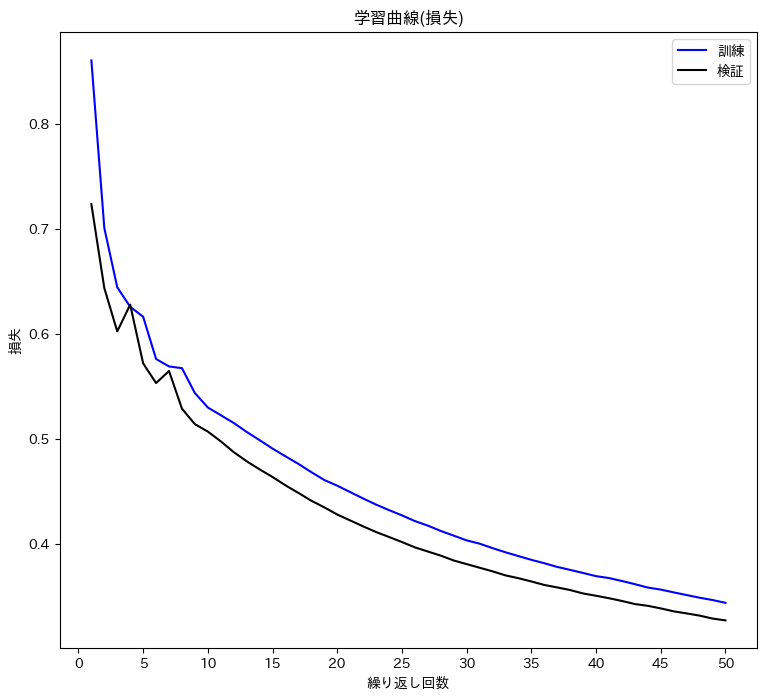

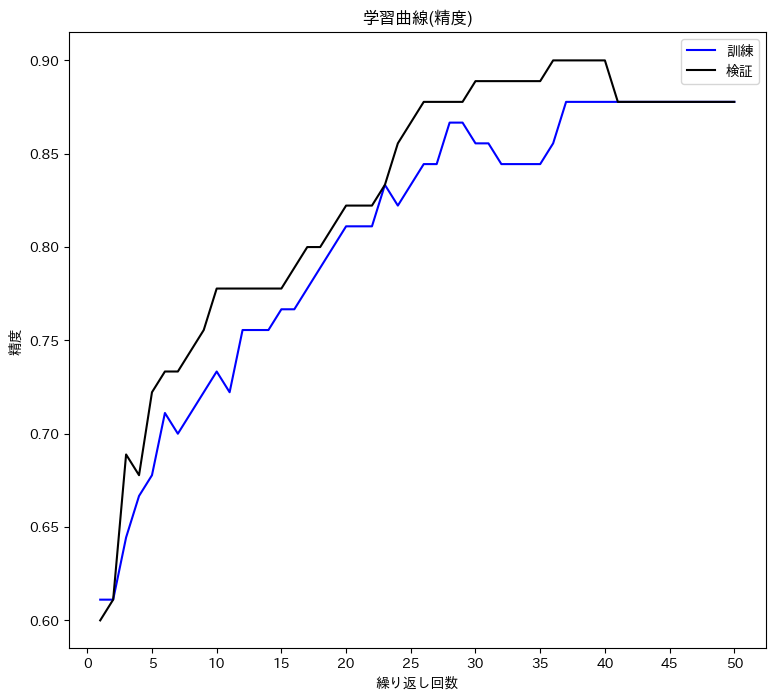

In [243]:
evaluate_history(history)

## 評価

In [244]:
class Evaluator:
  def __init__(self, csv_path, weights_path, save_csv_path, device):
    # csv_path : テストデータ
    # weights_path : 学習済みパラメータ
    # save_csv_path : 結果の保存先

    self.save_csv_path = save_csv_path

    #DataFrameで読み込み
    self.datalist = makeDataList(csv_path)

    n_input, n_output, n_hidden = 10, 2, 64
    self.net = Net(n_input, n_output, n_hidden, dropout_rate=0.0)
    self.net.load_state_dict(torch.load(weights_path))
    self.net.to(device)
    self.criterion = nn.CrossEntropyLoss()

  def writeCSV(self, predicted):
    result_df = pd.DataFrame({"PassengerId":self.datalist["PassengerId"].values, "Survived": predicted.to("cpu").detach().numpy().copy()})
    result_df.to_csv(self.save_csv_path, index=False)
    print(result_df)


  def evaluate(self):
    #評価フェーズ
    #self.net.eval()
    #Tensorに変換
    inputs = torch.from_numpy(self.datalist.drop(["PassengerId"], axis=1).values.astype(np.float32)).clone()
    inputs = inputs.to(device)

    with torch.no_grad():
      outputs = self.net(inputs)
      predicted = torch.max(outputs, dim=1)[1]

    self.writeCSV(predicted)




In [245]:
csv_path = "/content/drive/MyDrive/ColabData/kaggle-titanic/test.csv"
weights_path = '/content/drive/MyDrive/Colab Notebooks/kaggle-titanic/titanic03/model.pth'
save_csv_path = '/content/drive/MyDrive/Colab Notebooks/kaggle-titanic/titanic03/predict.csv'

In [246]:
evaluator = Evaluator(csv_path, weights_path, save_csv_path, device)
pred = evaluator.evaluate()


     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
